In [1]:
import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:

from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

2025-05-04 17:18:21.770623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746379101.972527      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746379102.031161      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd
from datasets import load_dataset

# Завантаження датасету
dataset = load_dataset('mavinsao/reddit-mental-illness-82')
df_tr = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_ts = dataset['test'].to_pandas()
df = pd.concat([df_tr, df_val, df_ts], axis=0, ignore_index=True)

# Перетворення тексту на нижній регістр
df['text'] = df['text'].str.lower()

# Фільтрація рядків за наявністю ключових слів
keywords = [
    "think i have", "i think i have", "i think it might be", "i think i could have",
    "might have", "i might have", "might be", "feel like i have", "i feel like i have",
    "feels like i have", "self-diagnose", "self-diagnosed", "i've self-diagnosed",
    "unsure if i have", "i'm unsure if", "unsure if this is", "wonder if i have",
    "i wonder if i have", "wonder if it's", "symptoms of", "i have symptoms of",
    "experiencing symptoms of", "suspect i have", "i suspect i have", "i suspect it's",
    "probably have", "i probably have", "i think i probably have", "could be", "it could be",
    "seems like i have", "it seems like i have", "it seems like", "not diagnosed but",
    "i am not diagnosed but", "i haven't been diagnosed but"
]

df = df[~df['text'].str.contains('|'.join(keywords), case=False, na=False)]

# Розбиття тексту на заголовок і основний текст
def split_text(row):
    if ':' in row:
        parts = row.split(':', 1)
        return parts[0].strip(), parts[1].strip()
    return None, row.strip()

df[['title', 'main_text']] = df['text'].apply(split_text).apply(pd.Series)

# Перевірка результату
print(df[['title', 'main_text', 'label']])


README.md:   0%|          | 0.00/755 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.04M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5264 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

                                                   title  \
0                              fantasizing about your fp   
1      this is a support subreddit for people with a ...   
2                        scared of my psychotic symptoms   
4      i feel like a sick animal that needs to be put...   
5      is constantly checking ocd subreddits a compul...   
...                                                  ...   
52637  i got diagnosed with pure o, and finding it di...   
52638                 where can i read up on propaganda?   
52639  need help "keeping thoughts straight," or, mai...   
52640  does anyone else feel like none of their exper...   
52641                         wish me luck at work today   

                                               main_text  label  
0      do you do it? what do you fantasize about? : w...      3  
1      it's not for posting how infuriating the uneve...      6  
2      i'm trying to keep reminding myself that what ...      2  
4      i had a 

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import spacy

# Функція очищення тексту
def clean_text(text):
    text = text.str.lower()
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace("\n", '', regex=True)
    text = text.str.replace('\d', '', regex=True)
    text = text.str.replace(r'\[.*?\]', '', regex=True)
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    text = text.str.replace(r'<.*?>+', '', regex=True)
    text = text.str.replace(r'\w*\d\w*', '', regex=True)
    return text

# Функція видалення стоп-слів
# custom_stopwords = {'ocd', 'anxiety', 'adhd', 'ptsd', 'bpd', 'depression', 'bipolar'}
custom_stopwords = {}
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(custom_stopwords)
    text = text.apply(lambda x: " ".join(word for word in str(x).split() if word.lower() not in stop_words))
    return text

# Функція лематизації
nlp = spacy.load('en_core_web_sm')

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

# Застосування функцій до обох стовпців
def process_text_columns(df, columns):
    for col in columns:
        # Очищення тексту
        df[col] = clean_text(df[col])
        # Видалення стоп-слів
        df[col] = remove_stopwords(df[col])
        # Видалення найчастіших слів
        delete = pd.Series(' '.join(df[col]).split()).value_counts()[-1000:]
        df[col] = df[col].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in delete))
        # Лематизація
        df[col] = df[col].apply(lemmatize_sentence)
    return df



df = pd.DataFrame(df)
# Застосування функцій до стовпців 'title' і 'main_text'
df = process_text_columns(df, ['title', 'main_text'])
print(df)


                                                    text  label  \
0      fantasizing about your fp: do you do it? what ...      3   
1      this is a support subreddit for people with a ...      6   
2      scared of my psychotic symptoms : i'm trying t...      2   
4      i feel like a sick animal that needs to be put...      4   
5      is constantly checking ocd subreddits a compul...      6   
...                                                  ...    ...   
52637  i got diagnosed with pure o, and finding it di...      6   
52638  where can i read up on propaganda? : i want to...      5   
52639  need help "keeping thoughts straight," or, mai...      0   
52640  does anyone else feel like none of their exper...      1   
52641  wish me luck at work today : oh god my anxiety...      1   

                                                   title  \
0                                           fantasize fp   
1                support subreddit people mental illness   
2              

In [5]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.3 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


   

# Об'єднання заголовку і основного тексту в один стовпець
df['text'] = df['title'].str.strip(':') + ' ' + df['main_text']
# df['text'] = df['main_text']
# Розподіл на X (тексти) та y (мітки)
X = df['text']
y = df['label']
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Застосування undersampling
X_res, y_res = undersampler.fit_resample(X.values.reshape(-1, 1), y)
print("Розподіл класів після балансування:")
print(pd.Series(y_res).value_counts())

balanced_df = pd.DataFrame({
    'text': X_res.flatten(),
    'label': y_res
})

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
print("\nРозподіл класів у тренувальному наборі:")
print(train_df['label'].value_counts())
print("\nРозподіл класів у тестовому наборі:")
print(test_df['label'].value_counts())


Розподіл класів після балансування:
label
0    4086
1    4086
2    4086
3    4086
4    4086
5    4086
6    4086
7    4086
Name: count, dtype: int64

Розподіл класів у тренувальному наборі:
label
5    3335
0    3296
1    3279
4    3264
6    3264
3    3260
2    3228
7    3224
Name: count, dtype: int64

Розподіл класів у тестовому наборі:
label
7    862
2    858
3    826
6    822
4    822
1    807
0    790
5    751
Name: count, dtype: int64


LGBM+BoW

Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.6832364637503824
Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.7043438360354849
Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Accuracy: 0.7213215050474151
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Accuracy: 0.7230039767513001
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Accuracy: 0.7386050780055062
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
Accuracy: 0.7513000917711838
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}
Accuracy: 0.7341694707861731
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
Accuracy: 0.7532884674212297
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_est

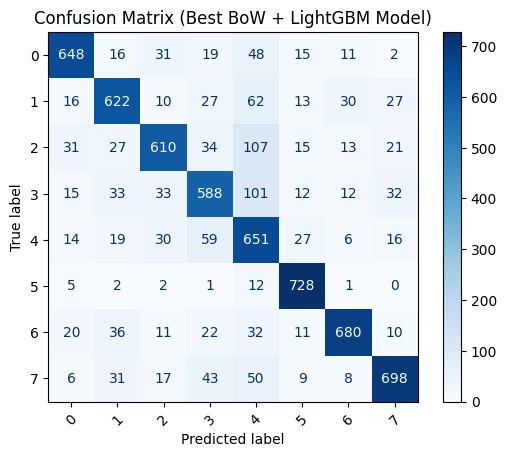

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


bow_vectorizer = CountVectorizer()
X_train = bow_vectorizer.fit_transform(train_df['text']).astype(np.float32)
X_test = bow_vectorizer.transform(test_df['text']).astype(np.float32)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Гіперпараметри для перебору
grid_params = {
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

param_grid = list(ParameterGrid(grid_params))
best_accuracy = 0
best_params = None
best_model = None

for params in param_grid:
    print(f"Training with parameters: {params}")
    lgbm_classifier = LGBMClassifier(
        random_state=42,
        verbose=-1,
        **params
    )
    lgbm_classifier.fit(X_train, y_train)

    y_test_pred = lgbm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = lgbm_classifier

# Підсумки
print("\nBest Parameters:", best_params)
print("Best Test Set Accuracy:", best_accuracy)

# Додатково — звіт
print("\nClassification Report (Best Model):")
y_best_pred = best_model.predict(X_test)
print(classification_report(y_test, y_best_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Best BoW + LightGBM Model)")
plt.show()


LGBM+Word2Vec

Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.5541449984704803
Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.5836647292750077
Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Accuracy: 0.600336494340777
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Accuracy: 0.5968185989599266
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Accuracy: 0.6215968185989599
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
Accuracy: 0.6318446007953502
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}
Accuracy: 0.5980422147445702
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
Accuracy: 0.6215968185989599
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_esti

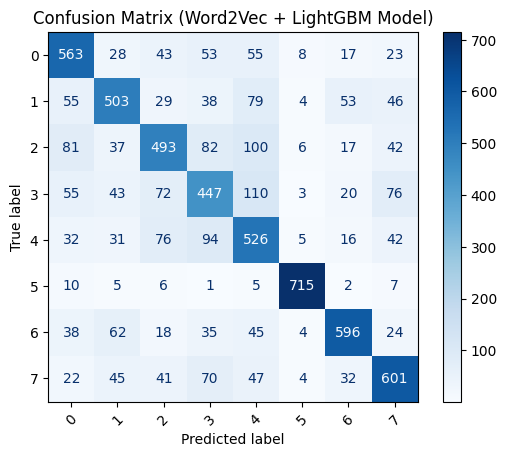

In [9]:
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np

# Токенізація тексту
train_tokens = train_df['text'].apply(lambda x: x.split())
test_tokens = test_df['text'].apply(lambda x: x.split())

# Навчання Word2Vec на train + test (можна й лише train)
all_tokens = list(train_tokens) + list(test_tokens)
w2v_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Функція для перетворення речення у середній вектор
def text_to_vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Отримання векторів
X_train = np.array([text_to_vec(tokens, w2v_model, 100) for tokens in train_tokens]).astype(np.float32)
X_test = np.array([text_to_vec(tokens, w2v_model, 100) for tokens in test_tokens]).astype(np.float32)

# Кодування міток
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Гіперпараметри
grid_params = {
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

param_grid = list(ParameterGrid(grid_params))
best_accuracy = 0
best_params = None
best_model = None

for params in param_grid:
    print(f"Training with parameters: {params}")
    lgbm_classifier = LGBMClassifier(random_state=42, verbose=-1, **params)
    lgbm_classifier.fit(X_train, y_train)

    y_test_pred = lgbm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = lgbm_classifier

# Результати
print("\nBest Parameters:", best_params)
print("Best Test Set Accuracy:", best_accuracy)
print("\nClassification Report (Best Model):")
y_best_pred = best_model.predict(X_test)
print(classification_report(y_test, y_best_pred))

# Матриця
cm = confusion_matrix(y_test, y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Word2Vec + LightGBM Model)")
plt.show()


LGBM+FastText

Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.4973998164576323
Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.5289079229122056
Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Accuracy: 0.5474151116549404
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Accuracy: 0.5451208320587335
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Accuracy: 0.5651575405322729
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
Accuracy: 0.5830529213826858
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}
Accuracy: 0.5443560721933313
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
Accuracy: 0.5697460997246865
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_est

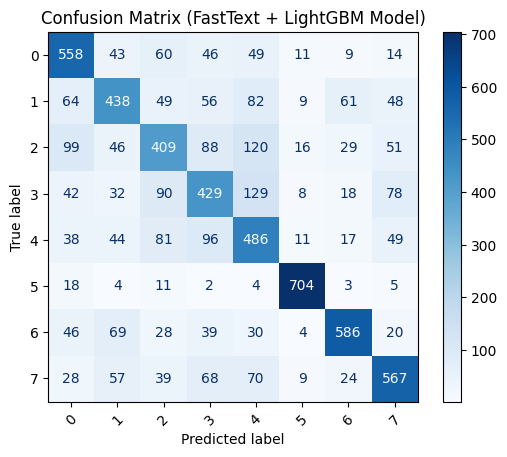

In [ ]:
from gensim.models import FastText
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np

train_tokens = train_df['text'].apply(lambda x: x.split())
test_tokens = test_df['text'].apply(lambda x: x.split())

# Навчання FastText
all_tokens = list(train_tokens) + list(test_tokens)
fasttext_model = FastText(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4, seed=42)

def text_to_vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)


X_train = np.array([text_to_vec(tokens, fasttext_model, 100) for tokens in train_tokens]).astype(np.float32)
X_test = np.array([text_to_vec(tokens, fasttext_model, 100) for tokens in test_tokens]).astype(np.float32)

# Перетворення міток
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Гіперпараметри
grid_params = {
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

param_grid = list(ParameterGrid(grid_params))
best_accuracy = 0
best_params = None
best_model = None

# Підбір моделі
for params in param_grid:
    print(f"Training with parameters: {params}")
    lgbm_classifier = LGBMClassifier(random_state=42, verbose=-1, **params)
    lgbm_classifier.fit(X_train, y_train)

    y_test_pred = lgbm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = lgbm_classifier

# Результати
print("\nBest Parameters:", best_params)
print("Best Test Set Accuracy:", best_accuracy)
print("\nClassification Report (Best Model):")
y_best_pred = best_model.predict(X_test)
print(classification_report(y_test, y_best_pred))

# Матриця плутанини
cm = confusion_matrix(y_test, y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (FastText + LightGBM Model)")
plt.show()


Logistic Regression + TF-IDF

Test Set Evaluation:
Accuracy: 0.788161517283573

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       790
           1       0.77      0.74      0.75       807
           2       0.79      0.70      0.74       858
           3       0.73      0.70      0.72       826
           4       0.63      0.77      0.69       822
           5       0.89      0.98      0.93       751
           6       0.90      0.81      0.85       822
           7       0.84      0.79      0.81       862

    accuracy                           0.79      6538
   macro avg       0.79      0.79      0.79      6538
weighted avg       0.79      0.79      0.79      6538


Confusion Matrix:
[[657  21  28  25  34  12   7   6]
 [ 35 596  13  30  60  12  31  30]
 [ 38  28 603  35  96  21  10  27]
 [ 25  31  44 576  97   9  11  33]
 [ 24  25  32  53 637  18   4  29]
 [  3   0   1   1   8 737   1   0]
 [ 22  37  16  23  34  13 669   8]
 [ 14  36  2

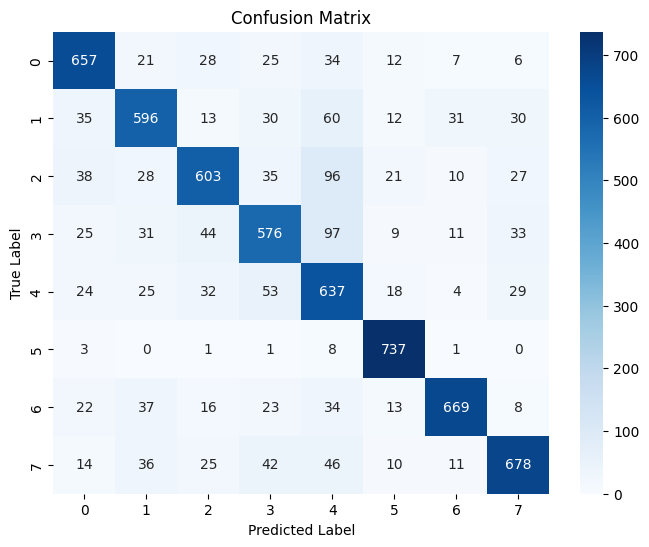

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Трансформація тексту в TF-IDF вектори
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])

# Перетворення текстових міток у числові значення
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Логістична регресія
logistic_regression_classifier = LogisticRegression(max_iter=100, random_state=892)
logistic_regression_classifier.fit(X_train, y_train)
y_test_pred = logistic_regression_classifier.predict(X_test)


print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")

print("\nClassification Report:")
class_names = label_encoder.classes_.astype(str)
print(classification_report(y_test, y_test_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


MultinomialNB

In [30]:
from sklearn.naive_bayes import MultinomialNB

# Наївний байєсівський класифікатор
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Прогнозування
y_test_pred_nb = nb_classifier.predict(X_test)

# Оцінка на тестовій вибірці
print("Test Set Evaluation (Naive Bayes):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_nb)}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_nb, target_names=class_names))


Test Set Evaluation (Naive Bayes):
Accuracy: 0.7303456714591618

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       790
           1       0.67      0.68      0.68       807
           2       0.88      0.55      0.67       858
           3       0.62      0.71      0.66       826
           4       0.57      0.77      0.66       822
           5       0.99      0.84      0.91       751
           6       0.91      0.70      0.79       822
           7       0.73      0.80      0.76       862

    accuracy                           0.73      6538
   macro avg       0.76      0.73      0.74      6538
weighted avg       0.76      0.73      0.73      6538



SVM

In [ ]:
from sklearn.svm import SVC

# Метод опорних векторів
svm_classifier = SVC(kernel='linear', random_state=892)
svm_classifier.fit(X_train, y_train)

y_test_pred_svm = svm_classifier.predict(X_test)

print("Test Set Evaluation (SVM):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_svm)}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_svm, target_names=class_names))


Test Set Evaluation (SVM):
Accuracy: 0.773325175894769

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       790
           1       0.74      0.73      0.74       807
           2       0.75      0.70      0.72       858
           3       0.70      0.69      0.70       826
           4       0.61      0.75      0.67       822
           5       0.93      0.97      0.95       751
           6       0.89      0.79      0.84       822
           7       0.84      0.77      0.80       862

    accuracy                           0.77      6538
   macro avg       0.78      0.78      0.78      6538
weighted avg       0.78      0.77      0.77      6538



K-nn

In [ ]:
from sklearn.model_selection import GridSearchCV

# Параметри для пошуку
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],

    'metric': ['euclidean', 'manhattan', 'minkowski']

}

# Створення моделі GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Виведення найкращих параметрів
print("Best Parameters from Grid Search:")
print(grid_search.best_params_)
y_test_pred_knn_optimized = grid_search.best_estimator_.predict(X_test)
print("Test Set Evaluation (Optimized k-NN):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_knn_optimized)}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_knn_optimized, target_names=class_names))


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters from Grid Search:
{'metric': 'euclidean', 'n_neighbors': 11}
Test Set Evaluation (Optimized k-NN):
Accuracy: 0.5780055062710309

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       790
           1       0.48      0.64      0.55       807
           2       0.65      0.40      0.50       858
           3       0.51      0.44      0.48       826
           4       0.41      0.55      0.47       822
           5       0.91      0.82      0.86       751
           6       0.72      0.65      0.68       822
           7       0.54      0.55      0.54       862

    accuracy                           0.58      6538
   macro avg       0.60      0.58      0.58      6538
weighted avg       0.60      0.58      0.58      6538



XGBoost


In [10]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# XGBoost
xgb_classifier = XGBClassifier(
    max_depth=3,
    n_estimators=300,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False
)
xgb_classifier.fit(X_train, y_train)
y_test_pred = xgb_classifier.predict(X_test)

print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(classification_report(y_test, y_test_pred))

Test Set Evaluation:
Accuracy: 0.7805139186295503
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       790
           1       0.77      0.76      0.77       807
           2       0.83      0.68      0.75       858
           3       0.73      0.67      0.70       826
           4       0.58      0.78      0.67       822
           5       0.81      0.97      0.88       751
           6       0.89      0.82      0.85       822
           7       0.86      0.80      0.83       862

    accuracy                           0.78      6538
   macro avg       0.79      0.78      0.78      6538
weighted avg       0.79      0.78      0.78      6538



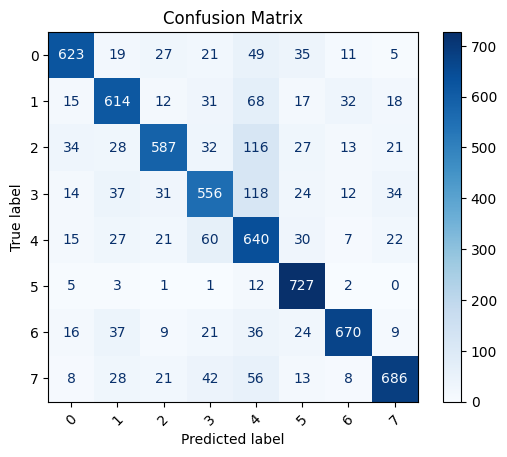

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Обчислення confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Візуалізація
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.793680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280240
[LightGBM] [Info] Number of data points in the train set: 26150, number of used features: 5001
[LightGBM] [Info] Start training from score -2.071140
[LightGBM] [Info] Start training from score -2.076311
[LightGBM] [Info] Start training from score -2.091986
[LightGBM] [Info] Start training from score -2.082122
[LightGBM] [Info] Start training from score -2.080896
[LightGBM] [Info] Start training from score -2.059377
[LightGBM] [Info] Start training from score -2.080896
[LightGBM] [Info] Start training from score -2.093226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

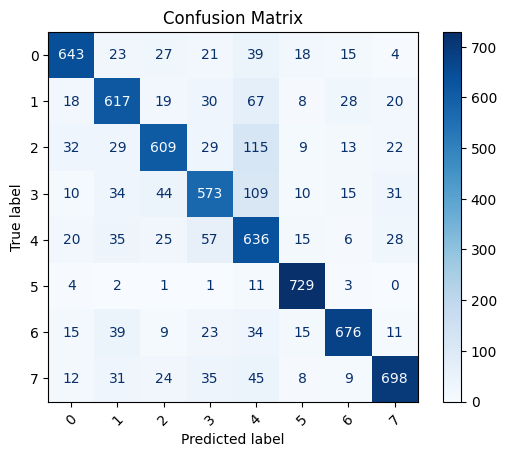

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# LightGBM
lgbm_classifier = LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
lgbm_classifier.fit(X_train, y_train)
y_test_pred = lgbm_classifier.predict(X_test)
print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


LGBM+TF-IDF

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Трансформація тексту в TF-IDF вектори
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Гіперпараметри для перебору
grid_params = {
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

param_grid = list(ParameterGrid(grid_params))
best_accuracy = 0
best_params = None
best_model = None

for params in param_grid:
    print(f"Training with parameters: {params}")
    lgbm_classifier = LGBMClassifier(
        random_state=42,
        verbose=-1, 
        **params
    )
    lgbm_classifier.fit(X_train, y_train)

    y_test_pred = lgbm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = lgbm_classifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\nBest Parameters:", best_params)
print("Best Test Set Accuracy:", best_accuracy)

print("\nClassification Report (Best Model):")
y_best_pred = best_model.predict(X_test)
print(classification_report(y_test, y_best_pred))
cm = confusion_matrix(y_test, y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Best Random Forest Model)")
plt.show()



Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.6956255735698991
Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.7127561945549098
Training with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Accuracy: 0.7248394004282656
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Accuracy: 0.7274395839706332
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Accuracy: 0.7419700214132763
Training with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
Accuracy: 0.7542061792597125
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}
Accuracy: 0.7379932701131845
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}
Accuracy: 0.7563475068828388
Training with parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_est


Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
Best Test Set Accuracy: 0.7924441725298257

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       790
           1       0.77      0.76      0.77       807
           2       0.79      0.72      0.75       858
           3       0.73      0.70      0.71       826
           4       0.61      0.78      0.68       822
           5       0.90      0.96      0.93       751
           6       0.89      0.82      0.86       822
           7       0.85      0.81      0.83       862

    accuracy                           0.79      6538
   macro avg       0.80      0.79      0.80      6538
weighted avg       0.80      0.79      0.79      6538



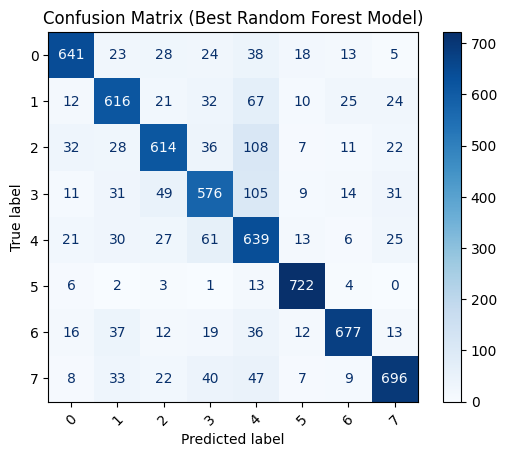

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\nBest Parameters:", best_params)
print("Best Test Set Accuracy:", best_accuracy)
print("\nClassification Report (Best Model):")
y_best_pred = best_model.predict(X_test)
print(classification_report(y_test, y_best_pred))

cm = confusion_matrix(y_test, y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Best Random Forest Model)")
plt.show()


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Трансформація тексту в TF-IDF вектори
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])

# Перетворення міток
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Гіперпараметри для перебору
grid_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid = list(ParameterGrid(grid_params))
best_accuracy = 0
best_params = None
best_model = None

for params in param_grid:
    print(f"Training with parameters: {params}")
    rf_classifier = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **params
    )
    rf_classifier.fit(X_train, y_train)

    y_test_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = rf_classifier

# Підсумки
print("\nBest Parameters:", best_params)
print("Best Test Set Accuracy:", best_accuracy)

# Додатково — звіт
print("\nClassification Report (Best Model):")
y_best_pred = best_model.predict(X_test)
print(classification_report(y_test, y_best_pred))


Training with parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7460997246864485
Training with parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.7635362496176201
Training with parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.7659834811869073
Training with parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.7528296115019883
Training with parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.7693484245946772
Training with parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.7705720403793209
Training with parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7613949219944938

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.919851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280196
[LightGBM] [Info] Number of data points in the train set: 26150, number of used features: 4997
[LightGBM] [Info] Start training from score -2.071140
[LightGBM] [Info] Start training from score -2.076311
[LightGBM] [Info] Start training from score -2.091986
[LightGBM] [Info] Start training from score -2.082122
[LightGBM] [Info] Start training from score -2.080896
[LightGBM] [Info] Start training from score -2.059377
[LightGBM] [Info] Start training from score -2.080896
[LightGBM] [Info] Start training from score -2.093226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

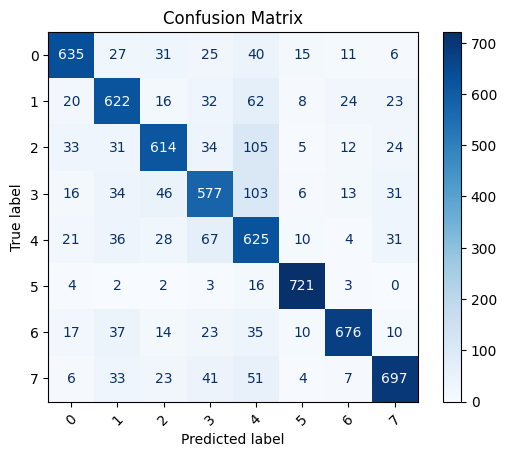

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt


tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# LightGBM
lgbm_classifier = LGBMClassifier(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    random_state=42
)
lgbm_classifier.fit(X_train, y_train)
y_test_pred = lgbm_classifier.predict(X_test)

print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
